In [1]:
# フォントを全て読み込み
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
pd.options.display.precision = 4
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
end='2022/12/31'
n225 = web.DataReader("NIKKEI225", 'fred',"1949/5/16",end).dropna()
develop=n225.loc[:'1989/12/31']
reform=n225.loc['1989/12/31':]

In [4]:
def mean_test_M(tsd):
    start=tsd.index[0].year
    end=tsd.index[-1].year
    years=np.arange(start,end+1,1)
    count=[0]*13
    alpha=0.1
    for i,y in enumerate(years):
        year=tsd.loc[str(y)]
        r=year.pct_change().resample('M').mean()
        s=year.pct_change().resample('M').std()
        n=year.pct_change().resample('M').count()
        tv=r/s*np.sqrt(n)
        t0=stats.t.ppf(1-alpha,len(r)-1)
        for m,tv0 in zip(tv.index.month,tv.values):
            count[m-1]+=len(tv0[tv0[0]>t0])
    count[m]=i+1
    return pd.DataFrame([count],index=["H0棄却数"],
                    columns=["1月","2月","3月","4月","5月","6月",
                             "7月","8月","9月","10月","11月","12月","年数"])

In [5]:
print('全期間：')
mean_test_M(n225)

全期間：


,1月,2月,3月,4月,5月,6月,7月,8月,9月,10月,11月,12月,年数
H0棄却数,25,15,14,11,14,10,9,16,18,12,15,16,74


In [6]:
print('バブル崩壊前:')
mean_test_M(develop)

バブル崩壊前:


,1月,2月,3月,4月,5月,6月,7月,8月,9月,10月,11月,12月,年数
H0棄却数,22,12,12,7,10,8,7,14,11,8,11,11,41


In [7]:
print('バブル崩壊後:')
mean_test_M(reform)

バブル崩壊後:


,1月,2月,3月,4月,5月,6月,7月,8月,9月,10月,11月,12月,年数
H0棄却数,3,3,2,4,4,2,2,2,7,4,4,5,33


In [8]:
def mean_test_W(tsd):
    start=tsd.index[0].year
    end=tsd.index[-1].year
    years=np.arange(start,end+1,1)
    rtsd=tsd.pct_change().dropna()
    count=[0]*6
    alpha=0.1
    for i,y in enumerate(years):
        year=rtsd.loc[str(y)]
        for j in range(5):
            m=year[year.index.weekday==j].iloc[:,0].mean()
            s=year[year.index.weekday==j].iloc[:,0].std()
            n=year[year.index.weekday==j].iloc[:,0].count()
            tv=m/s*np.sqrt(n)
            t0=stats.t.ppf(1-alpha,n-1)
            if tv>t0:
                count[j]+=1
    count[5]=i+1
    return pd.DataFrame([count],index=["H0棄却数"],
                        columns=["月","火","水","木","金","年数"])

In [9]:
print('全期間：')
mean_test_W(n225)

全期間：


,月,火,水,木,金,年数
H0棄却数,13,11,22,21,14,74


In [10]:
print('バブル崩壊前:')
mean_test_W(develop)

バブル崩壊前:


,月,火,水,木,金,年数
H0棄却数,10,7,19,13,12,41


In [11]:
print('バブル崩壊後:')
mean_test_W(reform)

バブル崩壊後:


,月,火,水,木,金,年数
H0棄却数,3,4,3,8,2,33


In [12]:
#データの取得と加工
start='1971/1/1'
#end='2016/8/31' #初版の分析期間
end='2021/12/31'
workpop = np.log(web.DataReader('LFWA64TTJPM647S',"fred",start,end).dropna())
workpop=workpop['1971':].resample('AS').last().dropna()
gdp = web.DataReader('MKTGDPJPA646NWDB',"fred",start,end).dropna()
gdp=gdp.resample('AS').last().dropna()
fx = web.DataReader('DEXJPUS',"fred",start,end).dropna()
fx=(fx.resample('AS').last()).iloc[1:].dropna()
gdpjpy=gdp.MKTGDPJPA646NWDB*fx.DEXJPUS
gdpjpy=np.log(gdpjpy).dropna()
lnfx=np.log(fx).dropna()
lnn225 = np.log(web.DataReader("NIKKEI225", 'fred',start,end).dropna())
lnn225=lnn225.resample('AS').last().iloc[1:].dropna()
port=pd.concat([workpop,gdpjpy,lnfx],axis=1).dropna()
port.columns=['workpop','gdpjpy','fx']

In [13]:
def petit_summary(res):
    print('------------------------------------------------------------------')
    print("　　　　　　　　　線形回帰　プチサマリーレポート")
    print('------------------------------------------------------------------')
    print(f"独立変数：      {res.model.endog_names}".ljust(35),
          "決定係数：".ljust(15),f"{res.rsquared:3.2f}")
    print(f"標本の大きさ：    {int(res.model.nobs):4d}".ljust(33),
          f"調整済み決定係数：   {res.rsquared_adj:3.2f}")
    print(f"残差の自由度：    {int(res.model.df_resid):4d}".ljust(33),
          f"F検定統計量：       {res.fvalue:3.2f}")
    print(f"モデルの自由度：  {int(res.model.df_model):4d}".ljust(32),
          f"Fp値：               {res.f_pvalue:3.2f}")
    print('------------------------------------------------------------------')
    print("　　　　　　　　　　　　　回帰係数")
    a=res.params.index.values
    reg=pd.DataFrame(np.transpose([res.params,res.tvalues,res.pvalues]),
                     index=a,columns=['coef','t-values','p>|t|'])
    print(reg)
    print('------------------------------------------------------------------')
    print('                      　　残差分析')
    print('------------------------------------------------------------------')
    print(f'ジャックベラ:{stats.jarque_bera(res.resid.values)[1]:2.2f}\
    歪度:{stats.skew(res.resid.values):2.2f}\
    尖度:{stats.kurtosis(res.resid.values):2.2f}\
    ダービンワトソン:{durbin_watson(res.resid.values):2.2f}')
    print('------------------------------------------------------------------')

In [14]:
def multi_regression(depen,explain):
    x=sm.add_constant(explain)
    res=sm.OLS(depen,x).fit()
    petit_summary(res)
    return res

In [15]:
res=multi_regression(port.gdpjpy,port.workpop)

------------------------------------------------------------------
　　　　　　　　　線形回帰　プチサマリーレポート
------------------------------------------------------------------
独立変数：      gdpjpy                   決定係数：           0.24
標本の大きさ：      50                   調整済み決定係数：   0.22
残差の自由度：      48                   F検定統計量：       14.86
モデルの自由度：     1                   Fp値：               0.00
------------------------------------------------------------------
　　　　　　　　　　　　　回帰係数
            coef  t-values  p>|t|
const   -42.7926   -2.1600 0.0358
workpop   4.1942    3.8555 0.0003
------------------------------------------------------------------
                      　　残差分析
------------------------------------------------------------------
ジャックベラ:0.81    歪度:-0.07    尖度:-0.43    ダービンワトソン:0.07
------------------------------------------------------------------


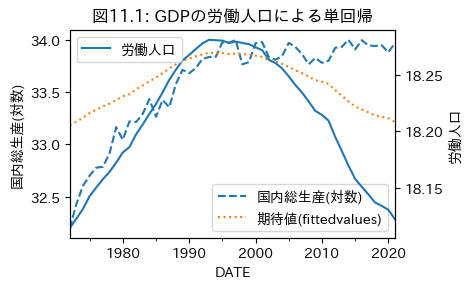

In [16]:
def doubleaxis_regression_plot(ylabel,ylabel2):
    fig,ax = plt.subplots(figsize=(5,3))#２軸のグラフの準備
    ax2=ax.twinx()#２軸目をax2として設定
    ax.set_ylabel(ylabel)#1軸目にラベルを設定
    ax2.set_ylabel(ylabel2)#2軸目にラベルを設定
    return fig,ax,ax2
fig,ax,ax2=doubleaxis_regression_plot('国内総生産(対数)','労働人口')
gdpjpy.plot(label='国内総生産(対数)',linestyle="--",ax=ax)
port.workpop.plot(label='労働人口',ax=ax2)#２軸目にプロット
res.fittedvalues.plot(label='期待値(fittedvalues)',style=':',ax=ax)
ax.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('図11.1: GDPの労働人口による単回帰')
plt.tight_layout()
#plt.savefig('図11.1.jpeg',dpi=600)
plt.show()

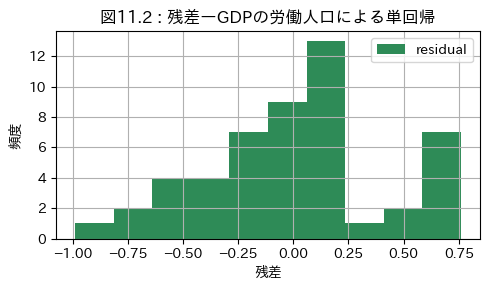

In [17]:
res.resid.hist(label='residual',color='seagreen',figsize=(5,3))
def plot_histogram_end(title):
    plt.xlabel('残差')
    plt.ylabel('頻度')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(title[:6]+'.jpeg',dpi=600)
    plt.show()
plot_histogram_end('図11.2 : 残差ーGDPの労働人口による単回帰')

In [18]:
results=[]
for i in ['n','c','ct']:
    results.append([sm.tsa.adfuller(workpop.diff().dropna(),regression=i)[1],
                    sm.tsa.adfuller(gdpjpy.dropna(),regression=i)[1],
                    sm.tsa.adfuller(lnn225,regression=i)[1],
                    sm.tsa.adfuller(lnfx.diff().dropna(),regression=i)[1]])
results=pd.DataFrame(results,index= ['n','c','ct'],
                     columns=['労働人口','GDP','lnN225','lnfx'])
print('表11.2: ADF検定')
results

表11.2: ADF検定


,労働人口,GDP,lnN225,lnfx
n,0.0531,0.8641,0.9251,0.0000
c,0.3684,0.0648,0.0092,0.0000
ct,0.0574,0.1576,0.0248,0.0008


In [19]:
res1=multi_regression(lnn225,port.iloc[:,0:2])

------------------------------------------------------------------
　　　　　　　　　線形回帰　プチサマリーレポート
------------------------------------------------------------------
独立変数：      NIKKEI225                決定係数：           0.57
標本の大きさ：      50                   調整済み決定係数：   0.55
残差の自由度：      47                   F検定統計量：       31.28
モデルの自由度：     2                   Fp値：               0.00
------------------------------------------------------------------
　　　　　　　　　　　　　回帰係数
            coef  t-values  p>|t|
const   -24.2076   -1.2791 0.2072
workpop   0.1909    0.1681 0.8672
gdpjpy    0.8988    6.8278 0.0000
------------------------------------------------------------------
                      　　残差分析
------------------------------------------------------------------
ジャックベラ:0.28    歪度:0.55    尖度:-0.00    ダービンワトソン:0.32
------------------------------------------------------------------


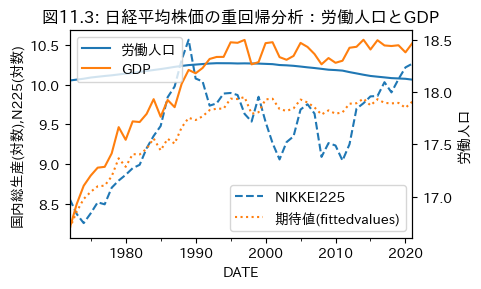

In [20]:
fig,ax,ax2=doubleaxis_regression_plot('国内総生産(対数),N225(対数)','労働人口')
lnn225.plot(label='n225',style="--",ax=ax)
port.workpop.plot(label='労働人口',ax=ax2)#２軸目にプロット
(port.gdpjpy-15.5).plot(label='GDP',ax=ax2)#２軸目にプロット
res1.fittedvalues.plot(label='期待値(fittedvalues)',style=':',ax=ax)
ax.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('図11.3: 日経平均株価の重回帰分析：労働人口とGDP')
plt.tight_layout()
#plt.savefig('図11.3.jpeg',dpi=600)
plt.show()

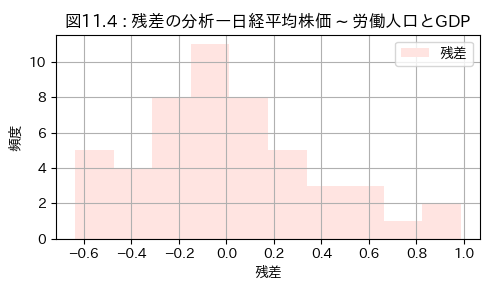

In [21]:
#多変量解析：ヒストグラム
res1.resid.hist(label='残差',color='mistyrose',figsize=(5,3))
plot_histogram_end('図11.4 : 残差の分析ー日経平均株価$\sim$労働人口とGDP')

In [22]:
#バブル崩壊前
resb=multi_regression(lnn225.loc[:'1990/1/1'],port.loc[:'1990/1/1'].iloc[:,0:2])

------------------------------------------------------------------
　　　　　　　　　線形回帰　プチサマリーレポート
------------------------------------------------------------------
独立変数：      NIKKEI225                決定係数：           0.94
標本の大きさ：      19                   調整済み決定係数：   0.93
残差の自由度：      16                   F検定統計量：       127.09
モデルの自由度：     2                   Fp値：               0.00
------------------------------------------------------------------
　　　　　　　　　　　　　回帰係数
             coef  t-values  p>|t|
const   -366.1494   -7.5987 0.0000
workpop   22.3945    6.7899 0.0000
gdpjpy    -0.9697   -2.5870 0.0199
------------------------------------------------------------------
                      　　残差分析
------------------------------------------------------------------
ジャックベラ:0.36    歪度:0.80    尖度:0.14    ダービンワトソン:1.85
------------------------------------------------------------------


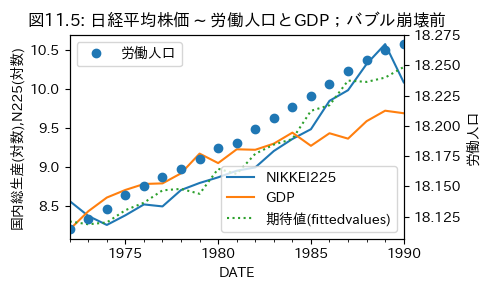

In [23]:
#バブル崩壊前のグラフ
fig,ax,ax2=doubleaxis_regression_plot('国内総生産(対数),N225(対数)','労働人口')
lnn225.loc[:'1990/1/1'].plot(label='n225',ax=ax)
port.workpop.loc[:'1990/1/1'].plot(label='労働人口',style='o',ax=ax2)#２軸目plt
(port.gdpjpy.loc[:'1990/1/1']-24).plot(label='GDP',ax=ax)#２軸目にプロット
resb.fittedvalues.plot(label='期待値(fittedvalues)',style=':',ax=ax)
ax.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('図11.5: 日経平均株価$\sim$労働人口とGDP；バブル崩壊前')
plt.tight_layout()
#plt.savefig('図11.5.jpeg',dpi=600)
plt.show()

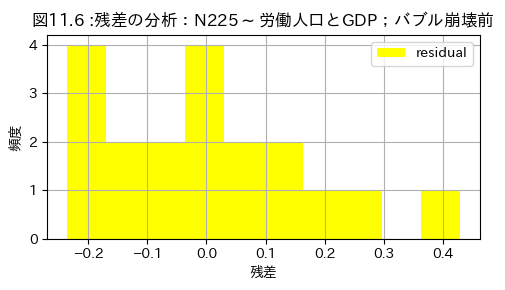

In [24]:
#バブル崩壊前：ヒストグラム
resb.resid.hist(label='residual',color='yellow',figsize=(5,3))
plot_histogram_end('図11.6 :残差の分析：N225$\sim$労働人口とGDP；バブル崩壊前 ')

In [25]:
#バブル崩壊後
resa=multi_regression(lnn225.loc['1990/1/1':],port.loc['1990/1/1':].iloc[:,0:2])

------------------------------------------------------------------
　　　　　　　　　線形回帰　プチサマリーレポート
------------------------------------------------------------------
独立変数：      NIKKEI225                決定係数：           0.12
標本の大きさ：      32                   調整済み決定係数：   0.06
残差の自由度：      29                   F検定統計量：       2.06
モデルの自由度：     2                   Fp値：               0.15
------------------------------------------------------------------
　　　　　　　　　　　　　回帰係数
           coef  t-values  p>|t|
const   24.7920    0.6563 0.5168
workpop -1.7690   -1.5141 0.1408
gdpjpy   0.5051    0.7026 0.4879
------------------------------------------------------------------
                      　　残差分析
------------------------------------------------------------------
ジャックベラ:0.54    歪度:-0.24    尖度:-0.83    ダービンワトソン:0.42
------------------------------------------------------------------


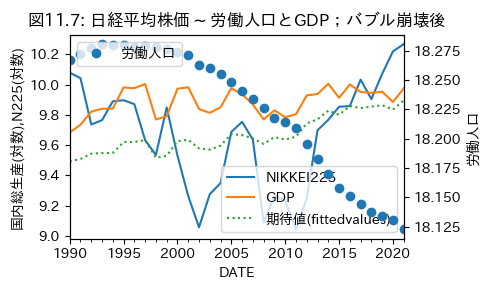

In [26]:
#バブル崩壊後のグラフ
fig,ax,ax2=doubleaxis_regression_plot('国内総生産(対数),N225(対数)','労働人口')
lnn225.loc['1990/1/1':].plot(label='n225',ax=ax)
port.workpop.loc['1990/1/1':].plot(label='労働人口',style='o',ax=ax2)#２軸目plt
(port.gdpjpy.loc['1990/1/1':]-24).plot(label='GDP',ax=ax)#２軸目にプロット
resa.fittedvalues.plot(label='期待値(fittedvalues)',style=':',ax=ax)
ax.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('図11.7: 日経平均株価$\sim$労働人口とGDP；バブル崩壊後')
plt.tight_layout()
#plt.savefig('図11.7.jpeg',dpi=600)
plt.show()

In [27]:
res2=multi_regression(lnn225.loc['1990/1/1':],port.loc['1990/1/1':])

------------------------------------------------------------------
　　　　　　　　　線形回帰　プチサマリーレポート
------------------------------------------------------------------
独立変数：      NIKKEI225                決定係数：           0.41
標本の大きさ：      32                   調整済み決定係数：   0.34
残差の自由度：      28                   F検定統計量：       6.42
モデルの自由度：     3                   Fp値：               0.00
------------------------------------------------------------------
　　　　　　　　　　　　　回帰係数
           coef  t-values  p>|t|
const   64.7502    1.9351 0.0631
workpop -2.8767   -2.8095 0.0089
gdpjpy  -0.2849   -0.4455 0.6594
fx       1.4916    3.6574 0.0010
------------------------------------------------------------------
                      　　残差分析
------------------------------------------------------------------
ジャックベラ:0.98    歪度:-0.09    尖度:0.03    ダービンワトソン:0.71
------------------------------------------------------------------


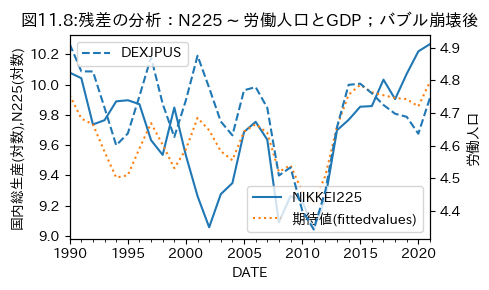

In [28]:
#バブル崩壊前のグラフ
fig,ax,ax2=doubleaxis_regression_plot('国内総生産(対数),N225(対数)','労働人口')
lnn225.loc['1990/1/1':].plot(label='n225',ax=ax)
(lnfx.loc['1990/1/1':]).plot(label='fx',linestyle="--",ax=ax2)
#(port.gdpjpy.loc['1990/1/1':]-24).plot(label='GDP',ax=ax)#２軸目にプロット
res2.fittedvalues.plot(label='期待値(fittedvalues)',style=':',ax=ax)
ax.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('図11.8:残差の分析：N225$\sim$労働人口とGDP；バブル崩壊後')
plt.tight_layout()
#plt.savefig('図11.8.jpeg',dpi=600)
plt.show()

In [29]:
#バブル崩壊後：細分化
states=['-1990','1990-','1990-2010','2000-','2010-','2013-']
starts=['1972/1/1','1990/1/1','1990/1/1','2000/1/1','2010/1/1','2013/1/1']
ends=['1990/1/1','2023/1/1','2010/1/1','2023/1/1','2023/1/1','2023/1/1']

In [30]:
def report(depen,port):
    x=sm.add_constant(port.iloc[:,:])
    res=sm.OLS(depen,x).fit()
    return res.rsquared,res.f_pvalue,res.pvalues.values[0],\
        res.pvalues.values[1], res.pvalues.values[2],\
        res.pvalues.values[3],sms.jarque_bera(res.resid)[1],len(depen)

In [31]:
factors=[["決定係数"," F-p値","p値:切片","労働人口","GDP","ドル円",\
          "JB p値","データ数"]]
da=[]
for i,(start,end) in enumerate(zip(starts,ends)):
    a,b,c,d,e,f,g,h=report(lnn225.loc[start:end],port.loc[start:end])
    factors.append([a,b,c,d,e,f,g,h])
    da.append(str(start)+"-"+str(end))
factors=pd.DataFrame(factors[1:],index=da,columns=factors[0])

In [32]:
print("表11.3: 日経株価平均の多重回帰")
factors

表11.3: 日経株価平均の多重回帰


,決定係数,F-p値,p値:切片,労働人口,GDP,ドル円,JB p値,データ数
1972/1/1-1990/1/1,0.9432,0.0000,0.0011,0.0013,0.0772,0.4353,0.2748,19
1990/1/1-2023/1/1,0.4075,0.0019,0.0631,0.0089,0.6594,0.0010,0.9767,32
1990/1/1-2010/1/1,0.3285,0.0733,0.1507,0.0763,0.5014,0.4788,0.4112,21
2000/1/1-2023/1/1,0.8149,0.0000,0.0400,0.0000,0.4721,0.0157,0.5887,22
2010/1/1-2023/1/1,0.9524,0.0000,0.0004,0.0002,0.2390,0.0733,0.7517,12
2013/1/1-2023/1/1,0.8571,0.0149,0.0074,0.0036,0.6601,0.7965,0.4015,9


In [33]:
start="2010/1/1"
end="2022/12/31"
fx =web.DataReader("DEXJPUS","fred",start,end).dropna()
jgb =web.DataReader("IRLTLT01JPM156N","fred",start,end)
ust =web.DataReader("DGS10","fred",start,end)

In [34]:
fxM=fx.copy().resample('MS').last().dropna()
dlnfxM=np.log(fxM).diff().dropna()
jgbM=jgb.copy().resample('MS').last().dropna()
ustM=ust.copy().resample('MS').last().dropna()
tsd=pd.concat([fxM,dlnfxM,jgbM,ustM],axis=1)
tsd2M=pd.concat([tsd.iloc[:,0:2],tsd.iloc[:,3]-tsd.iloc[:,2],
                 (tsd.iloc[:,3]-tsd.iloc[:,2]).pct_change()],axis=1).dropna()
tsd2M.columns=['fxM','dlnfxM','dInt','dInt%']

In [35]:
da,results=[],[]
factors=['ドル円','dln(ドル円)','日本国債',' 米国債:',' 金利差:']
for i in ['n','c','ct','ctt']:
    da.append(i)
    results.append([sm.tsa.adfuller(fxM,regression=i)[1],
    sm.tsa.adfuller(dlnfxM,regression=i)[1],
    sm.tsa.adfuller(jgbM,regression=i)[1],sm.tsa.adfuller(ustM,regression=i)[1],
    sm.tsa.adfuller(tsd2M.iloc[:,1:2],regression=i)[1]])
results=pd.DataFrame(results,index=da,columns=factors)
print("表11.4: ADF検定")
results

表11.4: ADF検定


,ドル円,dln(ドル円),日本国債,米国債:,金利差:
n,0.9251,0.0000,0.0068,0.4711,0.0000
c,0.7677,0.0000,0.1259,0.2218,0.0000
ct,0.5518,0.0000,0.9704,0.7579,0.0000
ctt,0.6954,0.0000,0.3210,0.8551,0.0000


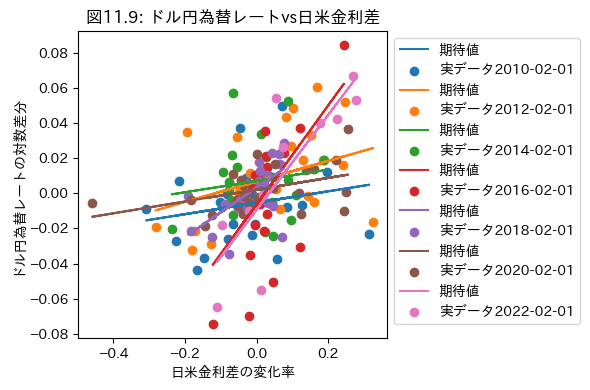

In [36]:
plt.figure(figsize=(6,4)) 
nnn=24
no=int(len(tsd2M)/nnn+1)
pred,resd,jb=[],[],0
for i in range(no):
    if i<no:
        tsd0=tsd2M.iloc[i*nnn:(1+i)*nnn].copy()
    else:
        tsd0=tsd2M.iloc[i*nnn:].copy()    
    X=sm.add_constant(tsd0.iloc[:,3].dropna())
    y=(tsd0.iloc[:,1]).dropna()
    y0=tsd0.iloc[0,0]
    y[0]=0
    model=sm.OLS(y,X)
    res=model.fit()
    pred.extend(res.fittedvalues.values.tolist())
    if i<=no-1:
        plt.plot(tsd0.iloc[:,3],res.fittedvalues,label='期待値')
        plt.scatter(tsd0.iloc[:,3],tsd0.iloc[:,1],\
                    label='実データ'+str(tsd0.index[0].date()))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('図11.9: ドル円為替レートvs日米金利差')
plt.xlabel('日米金利差の変化率')
plt.ylabel('ドル円為替レートの対数差分')
plt.tight_layout()
#plt.savefig('図11.9.jpeg',dpi=600)
plt.show()

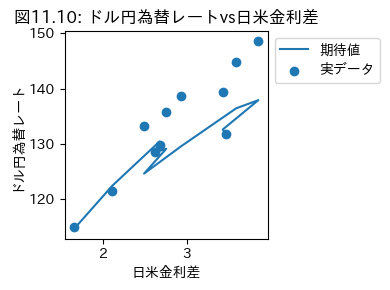

In [37]:
plt.figure(figsize=(4,3)) 
plt.plot(tsd0.iloc[:,2],np.exp(res.fittedvalues).cumprod()*y0,label='期待値')
plt.scatter(tsd0.iloc[:,2],tsd0.iloc[:,0],label='実データ')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('図11.10: ドル円為替レートvs日米金利差')
plt.xlabel('日米金利差')
plt.ylabel('ドル円為替レート')
plt.tight_layout()
#plt.savefig('図11.10.jpeg',dpi=600)
plt.show()